In [88]:
import io
import math
import os

import numpy as np
import pandas as pd
import seaborn as sns

In [89]:
# Change directory to scripts folder
directory = os.getcwd().split('/')[-1]

if directory == 'notebooks':
    %cd ..

In [90]:
# Matplotlib setup
import matplotlib

# matplotlib.use('PDF')

import matplotlib.pyplot as plt
print(f'matplotlib backend: {matplotlib.get_backend()}')

matplotlib backend: module://matplotlib_inline.backend_inline


In [104]:
incidents = pd.read_csv('proprietary_data/cleaned_data.csv', index_col=1, parse_dates=True, usecols=['tidspunkt', 'hastegrad'])
incidents

,hastegrad
tidspunkt,
2015-02-13 09:23:18,A
2015-02-13 14:01:29,A
2015-02-13 13:35:14,V1
2015-02-13 05:09:00,H
2015-02-13 16:00:39,V1
...,...
2016-12-14 11:00:00,V1
2017-12-15 09:00:00,V2
2016-11-03 08:00:00,V2


In [107]:
shifts = incidents.groupby(lambda t: 8 < t.hour < 20).value_counts()
shifts

tidspunkt  hastegrad
False      A            131563
           H            119887
           V1            21884
           V2            15341
           V                 4
True       A            181722
           H            165643
           V2            63570
           V1            55136
           V                52
dtype: int64

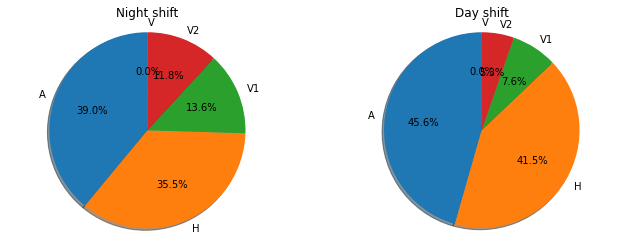

In [117]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11, 4))

labels = shifts[False].index
sizes_night = shifts[False].values
sizes_day = shifts[True].values


ax1.pie(sizes_day, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.set_title('Night shift')
ax1.axis('equal')
ax2.pie(sizes_night, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax2.set_title('Day shift')
ax2.axis('equal')

plt.show()